# Attribution of Responsibility and Blame in a Human-made Disaster: #FlintWaterCrisis

`Draft copy --please do not circulate without the consent of the authors.`

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth',200)
df = pd.read_pickle('../data/Flint.pkl')

from utilities.geocoder import Geocoder
gc = Geocoder('utilities/geodata/state_abbr_file', 'utilities/geodata/city_file')
df['latlon'] = df.location.str.strip().apply(gc.geocode)

from IPython.display import HTML
HTML(df.head().to_html(index=False))

created_at,followers,hashtagged,location,screen_name,text,verified,latlon
2016-01-15 21:00:24,265,True,"Sugar Land, Texas",zachsciba,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,"(29.599580, -95.614089)"
2016-01-15 21:00:07,968,True,None,scootey,You can thank the Republican party for this #Michigan #FlintWaterCrisis #GOP #Uniteblue https://t.co/wK7IFvkk8k,False,None
2016-01-15 21:00:30,189,True,"s. pasadena,ca",steve1204,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,"(34.112958, -118.155778)"
2016-01-15 21:00:09,8053,True,"Lansing, Michigan",ProgressMich,Snyder still won’t say when he knew about #FlintWaterCrisis. Protest with us on Tuesday to demand answers: https://t.co/aRfLc99QUy #MISOTS,False,"(42.717585, -84.554916)"
2016-01-15 21:00:35,7,True,None,marcgilbert77,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,None


In [15]:
#group tweets by day
import pytz
eastern = pytz.timezone('US/Eastern')
df.created_at = df.created_at.dt.tz_localize(pytz.utc).dt.tz_convert(eastern)

#print missing date intervals in our dataset
day = df.groupby(df.created_at.dt.strftime('%m-%d'))['created_at'].count()
days = day.index.tolist()
for i in range(len(days)-1):
    m1,d1 = days[i].split('-')
    m2,d2 = days[i+1].split('-')
    if m1 == m2:
        if int(d1) == int(d2) - 1:
            continue
    else:
        if d2 == '01':
            continue
    print('('+days[i]+','+days[i+1]+')',end=' ')

(01-22,01-25) (02-13,02-15) (02-16,02-20) (02-20,02-29) (02-29,03-03) (04-27,05-04) (05-06,05-08) (05-12,05-26) 

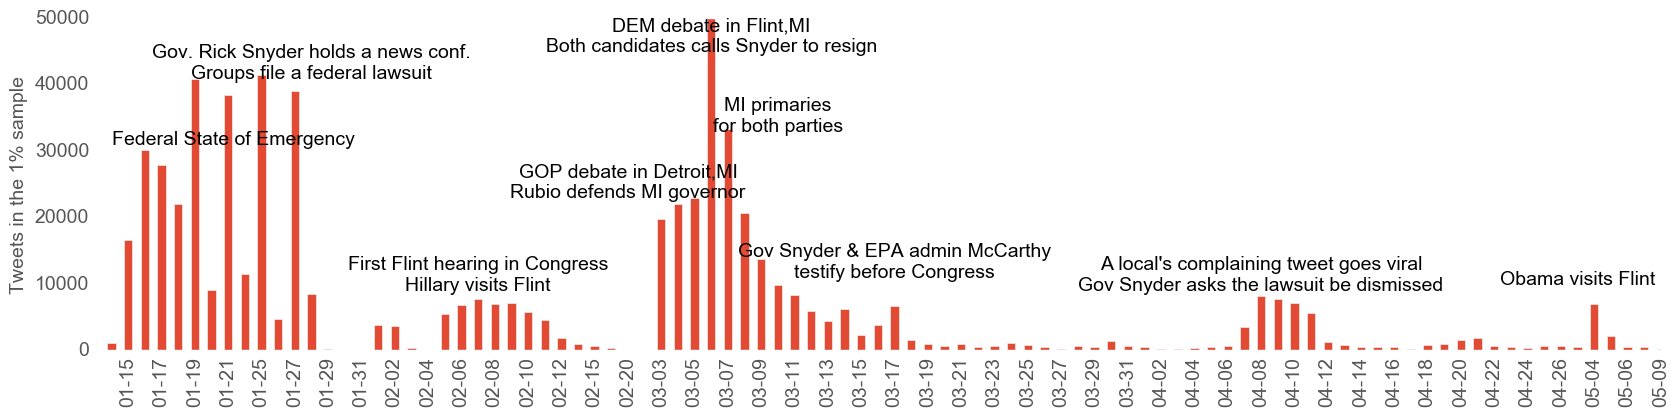

In [210]:
#Figure 1
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14
#plot daily activity
ax = day.plot(kind="bar",figsize=(18, 4)) #,title='#FlintWaterCrisis Activity on Twitter'
#ax.set_xlabel('Days After Flint Became a Federal State of Emergency on 2016-01-16', fontsize=14)
ax.set_ylabel('Tweets in the 1% sample', fontsize=14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.annotate('Federal State of Emergency', xy=(0, 31000))
ax.annotate('Gov. Rick Snyder holds a news conf.\n'\
            'Groups file a federal lawsuit', xy=(12, 41000),ha='center')
ax.annotate('First Flint hearing in Congress\n'\
            'Hillary visits Flint', xy=(22, 9000),ha='center')
ax.annotate('GOP debate in Detroit,MI\nRubio defends MI governor', xy=(31, 23000),ha='center')
ax.annotate('DEM debate in Flint,MI\nBoth candidates calls Snyder to resign', xy=(36, 45000),ha='center')
ax.annotate('MI primaries\nfor both parties', xy=(40, 33000),ha='center')
ax.annotate('Gov Snyder & EPA admin McCarthy\ntestify before Congress', xy=(47, 11000),ha='center')
ax.annotate('A local\'s complaining tweet goes viral\nGov Snyder asks the lawsuit be dismissed', xy=(69, 9000),ha='center')
ax.annotate('Obama visits Flint', xy=(88, 10000),ha='center')
ax.set_xlim([-1, 93])
ax.set_xlabel('');
ax.get_figure().savefig('../figs/daily.pdf',dpi=150,bbox_inches='tight')

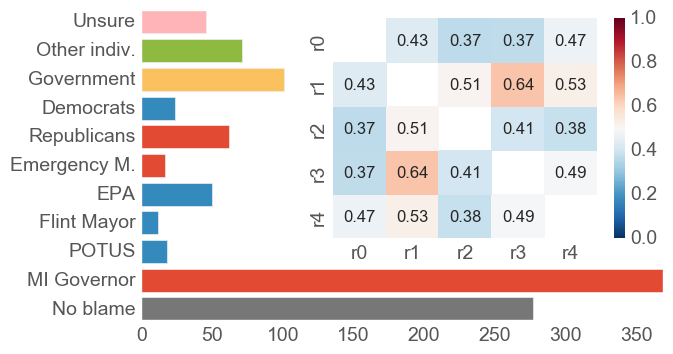

In [218]:
#Figure 2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')

plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14


l = pd.DataFrame()
for i in range(5):
    r = pd.read_csv('../data/training/Flint'+str(i+1)+'_train.csv')
    r['rater'] = i
    l = l.append(r)
l = l.fillna('missing')

l['label'] = l.c.replace({',.*':'','missing':10},regex=True).astype(int) #removes multiple labels

#get pairwise kappas
from itertools import combinations
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats.inter_rater import aggregate_raters

kappa = []
for r1,r2 in combinations(range(5), 2):
    rr = l[l.rater==r1].merge(l[l.rater==r2],on='text')[['label_x','label_y']]
    k = fleiss_kappa(aggregate_raters(rr,n_cat=11)[0])
    kappa.append(('r'+str(r1),'r'+str(r2),k))
    kappa.append(('r'+str(r2),'r'+str(r1),k)) #(r2,r1,k)

a = pd.DataFrame(kappa).pivot(0,1,2) #pairwise inter-rater fleiss-kappa 
a.index.name = None
a.columns.name = None


plt.figure(num=None, figsize=(6, 4), facecolor='w', edgecolor='w')

labels = ['No blame','MI Governor','POTUS','Flint Mayor',
          'EPA','Emergency M.','Republicans','Democrats','Government','Other indiv.', 'Unsure']
cnt = [len(l[l.c.str.contains(str(i))]) for i in range(10)] #count of each label
cnt.append(len(l[l.c.str.contains('missing')]))
ax = plt.subplot()
ax.margins(0, 0)
colors = '#777777 #E24A33 #348ABD #348ABD #348ABD #E24A33 #E24A33 #348ABD #FBC15E #8EBA42 #FFB5B8'.split()
#[color['color'] for color in list(plt.rcParams['axes.prop_cycle'])]
ax.barh(range(len(cnt)),cnt,tick_label=labels,align='center',color=colors)
#ax.set(xlabel='Manually coded tweets'); #title='Attribution of Blame/Responsibility',
#ax.grid(color='grey', linestyle='dotted', linewidth=0.5)


plt.axes([.4, .33, .55, .55])
sns.heatmap(a,annot=True,vmin=0,vmax=1,cmap='RdBu_r',annot_kws={'size':12})
ax.get_figure().savefig('../figs/coders.pdf',dpi=150,bbox_inches='tight')

In [6]:
#Table 1
df1 = pd.read_csv('../data/us-city-populations.csv',usecols=['CityST','2000','2010','LAT','LON','County_Name'])
df2 = pd.read_csv('../data/city_file.csv',dtype={'lat':str,'lon':str})
df2['CityST'] = df2.city + ', ' + df2.state
cities = df1.merge(df2, on = 'CityST', how = 'inner')
cities['latlon'] = cities[['lat','lon']].apply(tuple, axis=1)
cnt = pd.DataFrame(df.groupby(by='latlon').size().reset_index().rename(columns={0:'cnt'}))
cities = cities.merge(cnt,on='latlon',how='inner').rename(columns={'2010':'cpop','County_Name':'county'})
cities = cities[cities.cnt>=3]
cities.loc[cities.cpop.isnull(),'cpop'] = cities[cities.cpop.isnull()]['2000']
cities = cities.sort_values('cnt',ascending=False).reset_index().drop(['index','LAT','LON','2000'],1)
cities.cpop = cities.cpop.astype(int)
#cities.to_csv('data/cities.csv',index=False)
cities.head(10) #tweet counts without normalization

fil = cities[cities.cpop>88].copy()
fil['normalized'] = fil.cnt * 1000 / fil.cpop
fil = fil[fil.normalized>=1]
fil.sort_values('normalized',ascending=False).head(10) #normalized

city10 = fil.sort_values('normalized',ascending=False).head(10).reset_index()
city10 = city10.rename(columns={'CityST':'Cities'})

cofil = fil.groupby(['county','state']).sum()
cofil.normalized = cofil.cnt / np.sqrt(cofil.cpop)
county10 = cofil.sort_values(by='normalized',ascending=False).head(10).reset_index()
county10['Counties'] = county10.county +', '+county10.state

cc = pd.concat([city10.Cities,county10.Counties],axis=1)
cc.index += 1
print(cc.to_latex())

\begin{tabular}{lll}
\toprule
{} &                Cities &           Counties \\
\midrule
1  &             Flint, MI &        Genesee, MI \\
2  &           Gaylord, MI &  Dist Columbia, DC \\
3  &       Grand Blanc, MI &         Otsego, MI \\
4  &      Mount Morris, MI &          Wayne, MI \\
5  &  Bloomfield Hills, MI &         Ingham, MI \\
6  &           Lansing, MI &      Washtenaw, MI \\
7  &            Sedona, AZ &       Multiple, GA \\
8  &           Davison, MI &           Kent, MI \\
9  &     Traverse City, MI &       Coconino, AZ \\
10 &         Ann Arbor, MI &           Cook, IL \\
\bottomrule
\end{tabular}



In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

snyder = df.text.str.contains('governor|nyder|onetoughnerd',case=False)
EM = df.text.str.contains('mgr|manager|Darnell|Earley|Kurtz',case=False)
mayor = df.text.str.contains('Dayne|Walling|ayor',case=False)

In [129]:
snyderonly = df[snyder&~mayor&~EM].copy()
mayoronly=df[mayor&~snyder&~EM].copy()

snyderonly['sent'] = pd.DataFrame(list(snyderonly.text.apply(sid.polarity_scores)))['compound'].values
mayoronly['sent'] = pd.DataFrame(list(mayoronly.text.apply(sid.polarity_scores)))['compound'].values

-0.122567031844
-0.312806395394


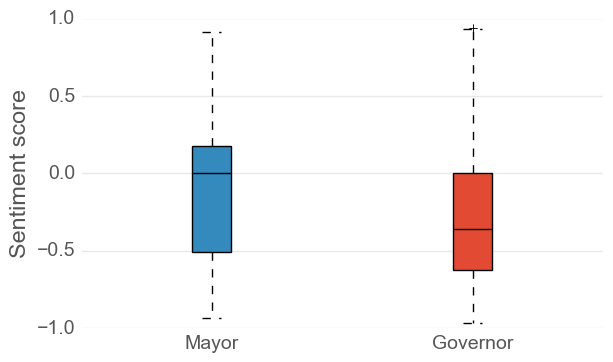

In [214]:
# Figure 3
mayonly_avgsent=pd.DataFrame(mayoronly.groupby(['screen_name'],as_index=False).mean()['sent'])
snyderonly_avgsent=pd.DataFrame(snyderonly.groupby(['screen_name'],as_index=False).mean()['sent'])


print(mayonly_avgsent.sent.mean())
print(snyderonly_avgsent.sent.mean())

# fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
colorm = dict(boxes='magenta', whiskers='black', medians='black', caps='black')
colorg = dict(boxes='lightgreen', whiskers='black', medians='black', caps='black')

#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14
#plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='w')

c = {'color':'black'}
m = {'color':'black','linestyle':'-'}
boxprops = dict(linestyle='-', color='black')
bp = plt.boxplot([mayonly_avgsent,snyderonly_avgsent], patch_artist=True,
                 whiskerprops=c,capprops=c,medianprops=m,boxprops=boxprops,labels=['Mayor','Governor'])

for patch, color in zip(bp['boxes'], ['#348ABD','#E24A33']):
    patch.set_facecolor(color)

ax = plt.gca()
ax.set_ylabel('Sentiment score')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_figure().savefig('../figs/box-mayor-gov.pdf',dpi=150,bbox_inches='tight')

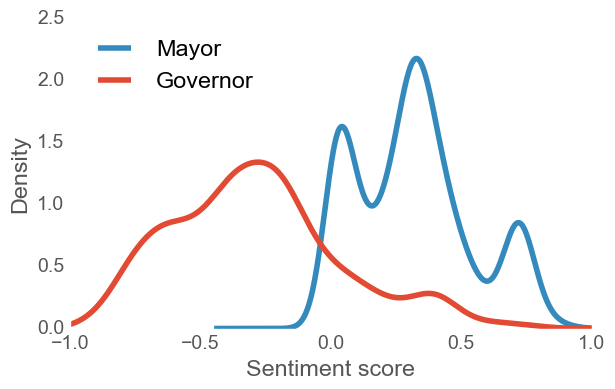

In [217]:
# Figure 4
mayonly_avgsent=pd.DataFrame(mayoronly.groupby(['screen_name'],as_index=False)['sent'].mean())
snyderonly_avgsent=pd.DataFrame(snyderonly.groupby(['screen_name'],as_index=False)['sent'].mean())

pro_may_avgent = mayonly_avgsent[mayonly_avgsent.sent>0].screen_name.unique()
comment_both = snyderonly_avgsent[snyderonly_avgsent.screen_name.isin(pro_may_avgent)].screen_name.unique()

ax=mayonly_avgsent[mayonly_avgsent.screen_name.isin(comment_both) & mayonly_avgsent.sent!=0].sent.plot(kind='density', xlim=(-1,1),color='#348ABD')
snyderonly_avgsent[snyderonly_avgsent.screen_name.isin(comment_both) & snyderonly_avgsent.sent!=0 ].sent.plot(kind='density', ax=ax, xlim=(-1,1), color = '#E24A33')
ax.legend(['Mayor','Governor'],loc=2)
ax.set_xlabel('Sentiment score')
ax.get_figure().savefig('../figs/pro_mayors_gov.pdf', bbox_inches='tight')

In [192]:
df['sent'] = pd.DataFrame(list(df.text.apply(sid.polarity_scores)))['compound'].values

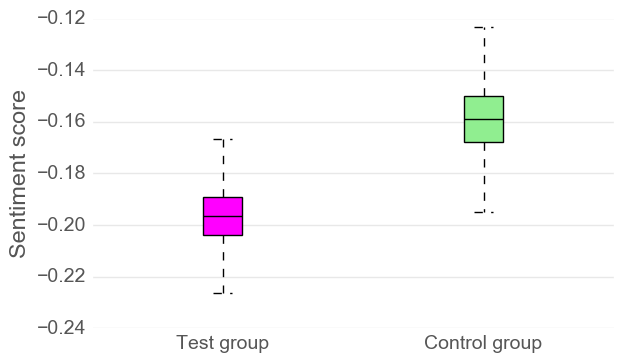

In [216]:
# Figure 5
compare = pd.read_table('../data/popVSfollower1000.txt',header=0, sep="\t")
colorm = dict(boxes='lightgreen', whiskers='black', medians='black', caps='black')
#ax=compare[['followers','population']].plot(kind='box', patch_artist=True, showfliers=False)
boxprops = dict(linestyle='-', color='black')
bp = plt.boxplot([compare.followers,compare.population],patch_artist=True, showfliers=False,
                 whiskerprops=c,capprops=c,medianprops=m,boxprops=boxprops,labels=['mayor','governor'])

ax = plt.gca()
for patch, color in zip(bp['boxes'], ['magenta','lightgreen']):
    patch.set_facecolor(color)
ax.xaxis.set_ticklabels(['Test group','Control group'])
ax.set_ylabel('Sentiment score')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_figure().savefig('../figs/contagion-exp.pdf', bbox_inches='tight')

# The rest is not used in the paper

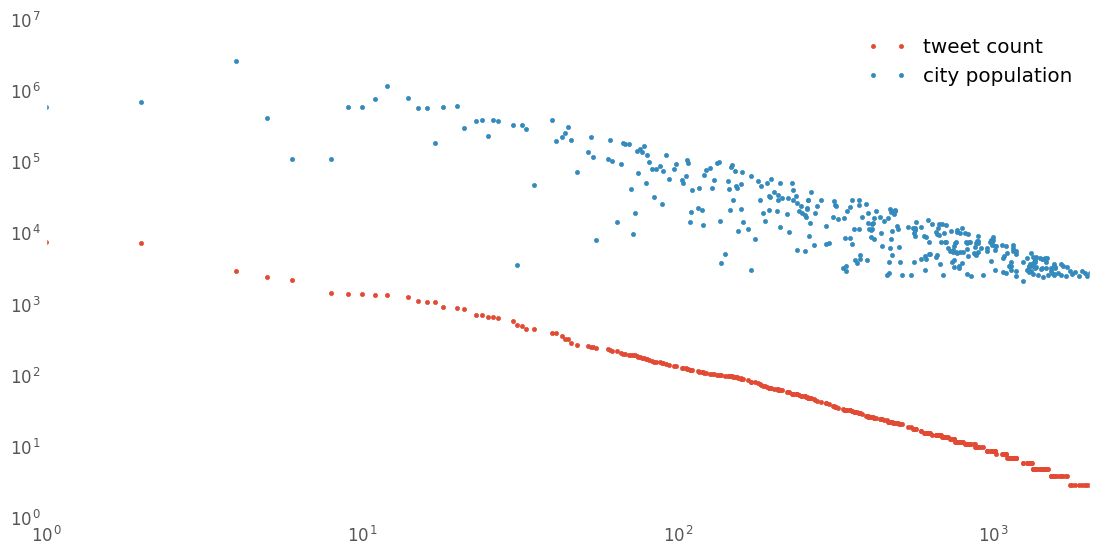

In [137]:
plt.figure(num=None, figsize=(12, 6), facecolor='w', edgecolor='w')
fil.cnt.plot(loglog=True,linestyle='',marker='.')
fil.cpop.plot(loglog=True,linestyle='',marker='.')
#fil.normalized.plot(loglog=True,linestyle='',marker='.')
plt.legend(['tweet count','city population']);

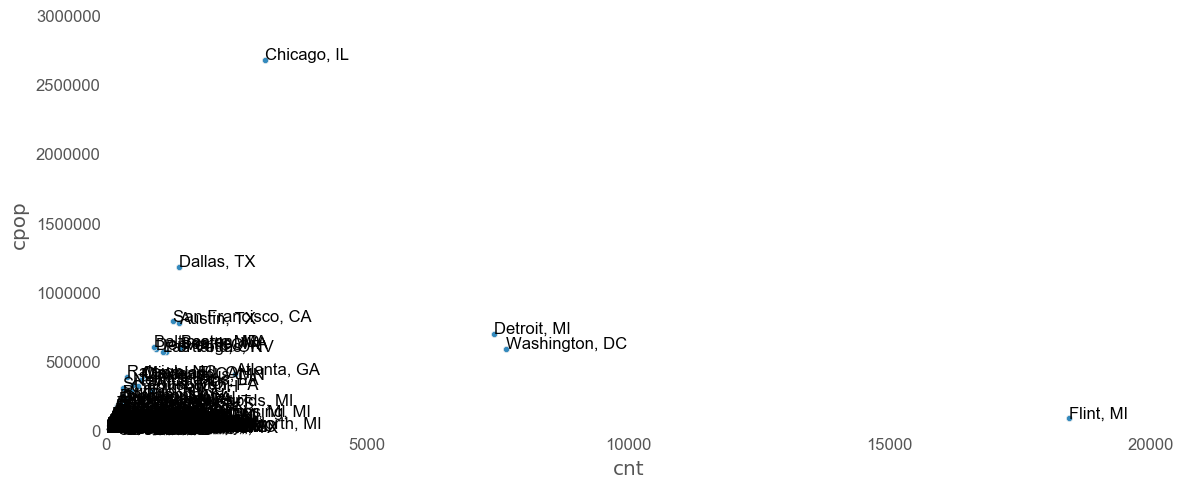

In [98]:
ax = fil.plot.scatter(x='cnt',y='cpop',figsize=(12,5))
fil[['cnt','cpop','CityST']].apply(lambda x: ax.text(*x),axis=1);
plt.xlim(0,20000);
plt.ylim(0,3000000);

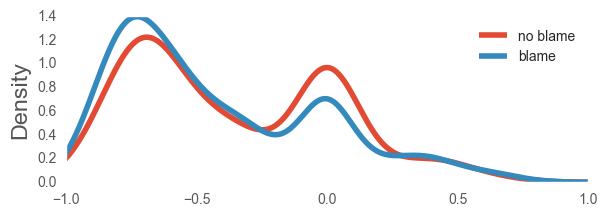

In [12]:
#compare the sentiments of blame and no-blame tweets
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
nobl = pd.DataFrame(list(l[l.c=='1'].text.apply(sid.polarity_scores)))['compound']
blame = pd.DataFrame(list(l[l.c!='2'].text.apply(sid.polarity_scores)))['compound']

nobl.plot.density()
blame.plot.density()
plt.legend(['no blame','blame'])
plt.xlim(-1,1);
plt.gcf().set_size_inches(6,2)
#plt.gcf().savefig('../figs/blame-sentiment.pdf',dpi=150,bbox_inches='tight')

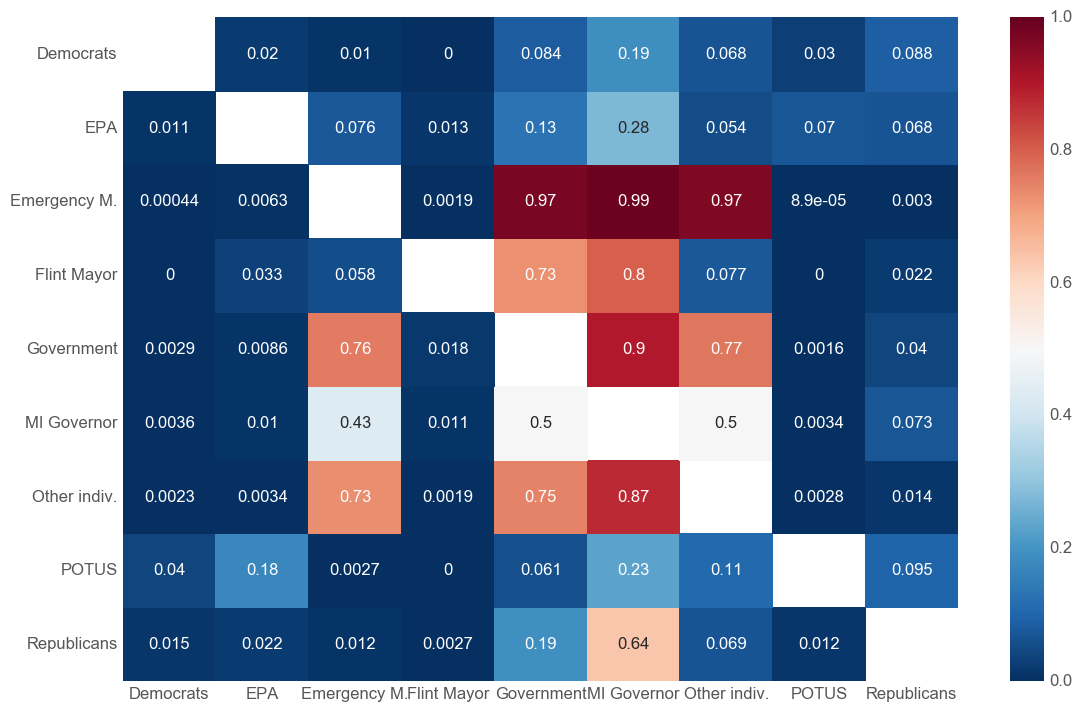

In [99]:
blamers = [df[df.text.isin(l[l.c.str.contains(str(i))].text.unique())].screen_name.unique() for i in range(10)]
blamers.append(df[df.text.isin(l[l.c == 'missing'].text.unique())].screen_name.unique())
blamers = pd.DataFrame(blamers).transpose()
blamers.columns = labels
blamers.apply(pd.Series.nunique) #number of (unique) blamers

from collections import defaultdict
from itertools import permutations
r = defaultdict(dict)
for a1,a2 in permutations(range(1,10), 2):
    s1 = set(df[df.screen_name.isin(blamers[labels[a1]])].text.unique())
    s2 = set(df[df.screen_name.isin(blamers[labels[a2]])].text.unique())
    r[labels[a1]][labels[a2]] = len(s1 & s2) / len(s2)
plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='w')
z = pd.DataFrame.from_dict(r) #what percentage of blamers of x also blame y
sns.heatmap(z,annot=True,vmin=0,vmax=1,cmap='RdBu_r',annot_kws={'size':12});

In [199]:
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from collections import defaultdict

synonyms = defaultdict(set)
words = 'blame fault responsible fail resign jail prison sentence accountable liable cause accuse treason poison'
for w in words.split():
    for synset in wn.synsets(w):
        synonyms[w].update([lemma.name() for lemma in synset.lemmas()])
from pprint import pprint
pprint(dict(synonyms),indent=2,width=300)

{ 'accountable': {'accountable'},
  'accuse': {'accuse', 'criminate', 'charge', 'incriminate', 'impeach'},
  'blame': {'goddamn', 'darned', 'damn', 'incrimination', 'goddamned', 'inculpation', 'fault', 'damned', 'blamed', 'charge', 'goddam', 'find_fault', 'deuced', 'blame', 'blasted', 'infernal', 'rap', 'pick', 'blessed'},
  'cause': {'causa', 'effort', 'movement', 'cause', 'suit', 'causal_agent', 'do', 'make', 'stimulate', 'drive', 'crusade', 'reason', 'campaign', 'case', 'lawsuit', 'induce', 'get', 'causal_agency', 'have', 'grounds'},
  'fail': {'give_way', 'give_out', 'run_out', 'miscarry', 'go_wrong', 'die', 'fail', 'flush_it', 'bomb', 'break', 'neglect', 'conk_out', 'go_bad', 'flunk', 'betray', 'go', 'break_down'},
  'fault': {'shift', 'error', 'faulting', 'mistake', 'geological_fault', 'defect', 'break', 'fault', 'flaw', 'demerit', 'fracture', 'blame'},
  'jail': {'lag', 'poky', 'jail', 'jailhouse', 'incarcerate', 'remand', 'clink', 'slammer', 'imprison', 'immure', 'pokey', 'jug'

In [208]:
blame_words = {'responsible': 'account responsible blame accus[ie] \sliab \scause',
    'fault': 'fault error mistake flaw',
    'reason': 'ignor negl[ie] accident discriminat intention ideology decisi',
    'sentenced': 'arrest convict jail jug bars prison sentence',
    'betrayed': 'betray traitor treason',
    'resign': 'resign quit remove.+office leave.+office step\sdown',
    'poison': 'poison'}
bw = {}
for k,v in blame_words.items():
    bw[k] = v.split()
bw = pd.DataFrame.from_dict(blame_words, orient='index').rename(columns={0:'blame words per category'})

print(bw.to_latex())

\begin{tabular}{ll}
\toprule
{} &                                       blame words per category \\
\midrule
fault       &                                       fault error mistake flaw \\
poison      &                                                         poison \\
betrayed    &                                         betray traitor treason \\
responsible &             account responsible blame accus[ie] \textbackslashsliab \textbackslashscause \\
sentenced   &                   arrest convict jail jug bars prison sentence \\
resign      &           resign quit remove.+office leave.+office step\textbackslashs down \\
reason      &  ignor negl[ie] accident discriminat intention ideology decisi \\
\bottomrule
\end{tabular}



In [212]:
blame_words = {'responsible': 'account responsible blame accus[ie] \sliab \scause',
    'fault': 'fault error mistake flaw',
    'reason': 'ignor negl[ie] accident discriminat intention ideology decision',
    'sentenced': 'arrest convict jail jug bars prison sentence',
    'betrayed': 'betray traitor treason',
    'resign': 'resign quit remove.+office leave.+office step\sdown',
    'poison': 'poison'}
blame_tw = {} #unique text
blame_rt = {} #rt matters
total = set()
for k,v in blame_words.items():
    indices = set.union(*[set(df[df.text.str.contains(w,case=False)].index) for w in v.split()])
    blame_tw[k] = df.loc[indices,].text.nunique()
    blame_rt[k] = len(indices)
    total.update(indices)
blame_rt['total'] = len(total)
blame_tw['total'] = df.loc[total,].text.nunique()
pd.DataFrame([blame_rt,blame_tw],index=['tweets in the dataset (RTs count)','# of tweets w/ unique text'])

,betrayed,fault,poison,reason,resign,responsible,sentenced,total
tweets in the dataset (RTs count),400,6047,51513,9233,17224,20961,20809,113340
# of tweets w/ unique text,292,2851,19338,4288,7795,11886,9663,50700


In [213]:
l = [v.split() for v in blame_words.values()]
blame_filter = '|'.join([item for sublist in l for item in sublist])
blames = df[df.text.str.contains(blame_filter,case=False)].copy()
blames = blames.replace({'\r': ' ','\n': ' '}, regex=True)

In [249]:
# group by tweet text
grouped = blames.groupby('text').size()
g = grouped.reset_index().rename(columns={0:'RT'})
g = g.sort_values('RT',ascending=False)

In [196]:
"""
sample = g.sample(n=2000,random_state=3).sort_values('RT',ascending=False).copy()
s1 = sample.sample(n=200,random_state=5)
s2 = sample.sample(n=200,random_state=7)
s3 = sample.sample(n=200,random_state=9)
s4 = sample.sample(n=200,random_state=11)
s5 = sample.sample(n=200,random_state=13)
s6 = sample.sample(n=200,random_state=15)

from itertools import combinations
for p,q in combinations(range(1,5),2):
    p = 's'+str(p)
    q = 's'+str(q)
    print('|'+p+'|','∩','|'+q+'|','=',len(set(eval(p).index)&set(eval(q).index)))

s1.to_csv('data/s1.csv',index=False)
s2.to_csv('data/s2.csv',index=False)
s3.to_csv('data/s3.csv',index=False)
s4.to_csv('data/s4.csv',index=False)
s5.to_csv('data/s5.csv',index=False)
s6.to_csv('data/s6.csv',index=False)
"""

In [30]:
snyder = blames.text.str.contains('gov|nyder|onetoughnerd|bern',case=False)
em = blames.text.str.contains('mgr|manager|Darnell|Earley|Kurtz',case=False)
mayor = blames.text.str.contains('Dayne|Walling|ayor',case=False)
obama = blames.text.str.contains('obama|POTUS',case=False)
obama = obama & ~blames.text.str.contains('pledge|announc|nyder|governor',case=False)
epa = blames.text.str.contains('\sEPA\s',case=False)
republic = blames.text.str.contains('republic',case=False)
democrat = blames.text.str.contains('democrat',case=False)

In [32]:
def perform(fun, *args):
    return fun(*args)

def meetmin(x,y):
    x = blames[x].screen_name
    y = blames[y].screen_name
    return 100 * len(set(x) & set(y)) / min(len(set(x)), len(set(y)))

In [33]:
scores = []
s = snyder& ~(epa|obama|mayor|em)
for y in [s,epa,obama,mayor,em]:
    for f in [meetmin]:
        scores.append({'EM':perform(f,em,y),
                      'Mayor':perform(f,mayor,y),
                      'President':perform(f,obama,y),
                      'EPA':perform(f,epa,y),
                      'Snyder':perform(f,s,y)})
pd.DataFrame(scores,index=['Also blame Snyder','Also blame EPA','Also blame President','Also blame Mayor','Also blame EM'])

,EM,EPA,Mayor,President,Snyder
Also blame Snyder,33.592881,18.976198,20.074349,30.438675,100.000000
Also blame EPA,7.730812,100.000000,8.550186,15.219338,18.976198
Also blame President,6.893465,15.219338,6.195787,100.000000,30.438675
Also blame Mayor,9.293680,8.550186,100.000000,6.195787,20.074349
Also blame EM,100.000000,7.730812,9.293680,6.893465,33.592881


### Crowdsourcing

We filtered our dataset using blame words and labeled one percent sample of the tweets manually regarding who the blame is attributed to. 

- 0: not a blame tweet
- 1: MI Gov. Rick Snyder @onetoughnerd
- 2: POTUS Obama
- 3: Flint Mayor Dayne Walling
- 4: EPA / Gina McCarthy
- 5: Emergency Managers: Darnell|Earley|Kurtz
- 6: Republicans (help crisis grow)
- 7: Democrats (help crisis grow)
- 8: Government
- 9: Other specified (not among the listed above).

Reviwers also identified whether they were confused or unsure about who the tweet assigns blame to.



In [106]:
import pandas as pd
l = pd.DataFrame()
for i in range(5):
    r = pd.read_csv('data/training/Flint'+str(i+1)+'_train.csv')
    r['rater'] = i
    l = l.append(r)
l = l.fillna('missing')

In [23]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
inset_axes = inset_axes(parent_axes,
                    width="30%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc=3)

19.1 2.5079872408


In [117]:
df = pd.read_csv('data/us-city-populations.csv',usecols=['CityST','2010','LAT','LON'])
df2 = pd.read_csv('data/city_file.csv',dtype={'lat':str,'lon':str})
df2['CityST'] = df2.city + ', ' + df2.state
merged = df.merge(df2, on = 'CityST', how = 'inner')
merged['latlon'] = merged[['lat','lon']].apply(tuple, axis=1)

In [120]:
merged.head()

,CityST,2010,LAT,LON,city,state,lat,lon,latlon
0,"Anchorage, AK",291826.0,61.177549,-149.274354,Anchorage,AK,61.191900,-149.762097,"(61.191900, -149.762097)"
1,"Barrow, AK",4212.0,71.254083,-156.798949,Barrow,AK,71.300371,-156.735840,"(71.300371, -156.735840)"
2,"Bethel, AK",6080.0,60.792913,-161.793405,Bethel,AK,60.789724,-161.779332,"(60.789724, -161.779332)"
3,"Fairbanks, AK",31535.0,64.836531,-147.651745,Fairbanks,AK,64.838092,-147.726378,"(64.838092, -147.726378)"
4,"Homer, AK",5003.0,59.639985,-151.511234,Homer,AK,59.643059,-151.525900,"(59.643059, -151.525900)"


In [260]:
pos = {}
neg = {}
mean = {}
for g in ('s','epa','obama','mayor','em'):
    pos[g]=len(blames[(blames.sp>0) & eval(g)].text.unique())
    neg[g]=len(blames[(blames.sp<0) & eval(g)].text.unique())
    mean[g] = blames[(blames.sp<0) & eval(g)].sp.mean()
pd.DataFrame([pos,neg,mean],index=['pos tw unique','neg tw unique','mean'])

,em,epa,mayor,obama,s
pos tw unique,137.000000,309.000000,102.000000,183.000000,1454.000000
neg tw unique,94.000000,245.000000,120.000000,320.000000,2266.000000
mean,-0.295925,-0.366463,-0.160341,-0.344728,-0.342608


In [30]:
with pd.option_context('display.max_colwidth', 114):
    print(blames[epa].text[:30].to_string(index=False))

id
RT @NolanHack: Navajo Blame EPA Inaction For Suicides\n\n#FlintWaterCrisis \nhttps://t.co/wgPjnIGRIg #StopNati...
MidwestViews: #FlintWaterCrisis Politics as usual BernieSanders &amp; Dems want onetoughnerd resign but not ep...
@billmaher\nAfter the Flint disaster, you may accept the fact that EPA never implemented the CWA due to a faul...
@MaddowBlog\nAfter the Flint disaster,you may accept the fact that EPA never implemented the CWA due to a faul...
@chrislhayes\nAfter Flint disaster, you may accept the fact that EPA never implemented the CWA due to a faulty...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
                                 Government #EPA has failed #FlintWaterCrisis   Obama

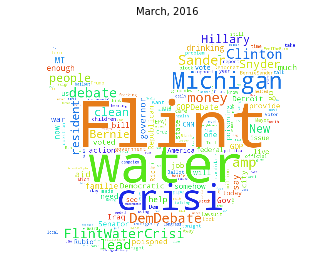

In [21]:
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
from PIL import Image
import numpy as np
import calendar
#mask = imread('twitter_mask.png', flatten=True)
mask = np.array(Image.open("twitter_mask.png"))
wc = WordCloud(mask=mask,background_color='white',stopwords=STOPWORDS,width=2200,height=1400).generate(words)
plt.figure().suptitle(calendar.month_name[month]+', 2016')
plt.axis('off')
plt.imshow(wc)
plt.savefig('figs/wc_'+calendar.month_name[month]+'.png', dpi=300, bbox_inches='tight')